In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os, cv2
from tqdm.auto import tqdm

In [3]:
!mkdir -p /root/.kaggle
!mv /content/kaggle.json /root/.kaggle

In [4]:
import kaggle

In [5]:
!kaggle competitions download dog-breed-identification

100% 688M/691M [00:27<00:00, 30.7MB/s]
100% 691M/691M [00:27<00:00, 25.9MB/s]


In [6]:
!unzip -q /content/dog-breed-identification.zip

In [7]:
!rm /content/dog-breed-identification.zip

In [8]:
df = pd.read_csv('/content/labels.csv')

In [9]:
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
len(os.listdir('/content/train')),df.shape

(10222, (10222, 2))

In [11]:
length = []
width = []
for i in os.listdir('/content/train'):
  image = cv2.imread(os.path.join('/content/train/',i))
  length.append(image.shape[0])
  width.append(image.shape[1])

In [12]:
#the average length and width of dog breed images
np.mean(length),np.mean(width)

(386.74721189591077, 443.33153981608297)

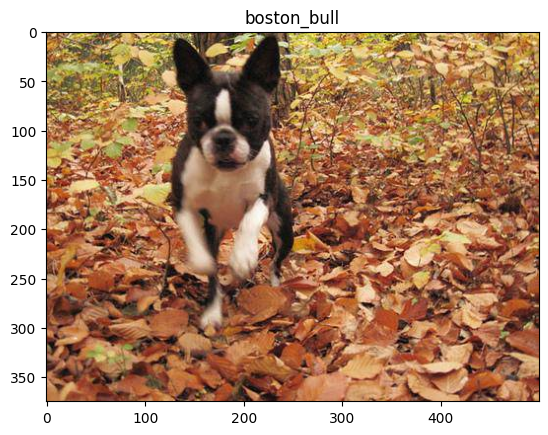

In [ ]:
img = '000bec180eb18c7604dcecc8fe0dba07.jpg'
image = cv2.imread(os.path.join('/content/train/',img))
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)
img = img.split('.')[0]
plt.title(df[df['id']==img].breed.values[0])
plt.show()

In [ ]:
df.breed.nunique()

120

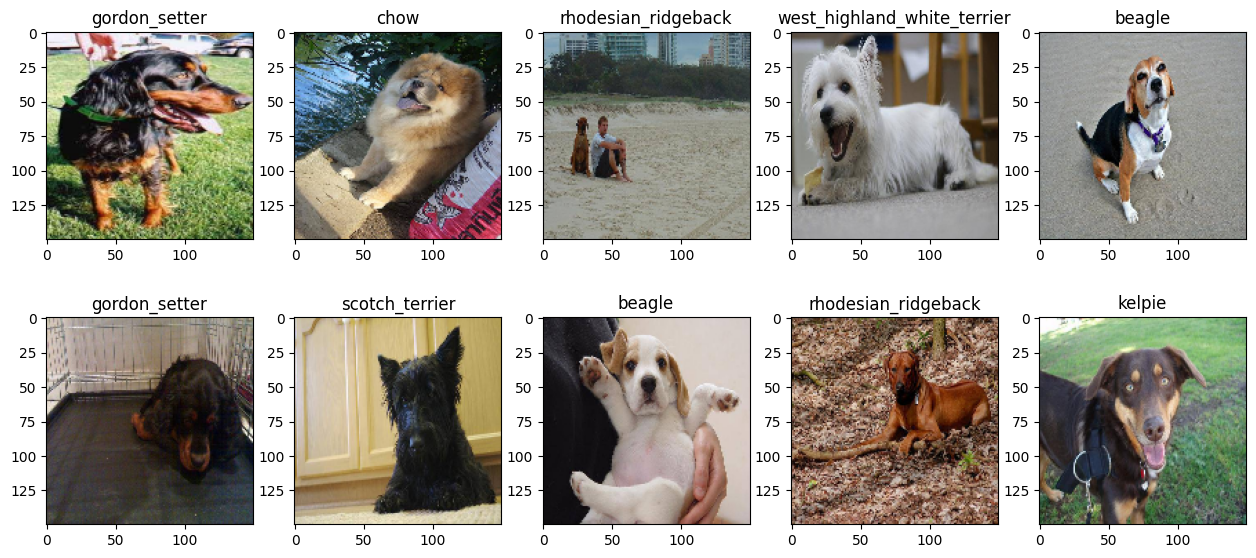

In [ ]:
img = np.random.choice(os.listdir('/content/train'),10,replace = False)
for idx,i in enumerate(img):
  image = cv2.imread(os.path.join('/content/train',i))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(150,150))
  im = i.split('.')[0]
  tag = df[df['id']==im].breed.values[0]
  plt.subplot(2,5,idx+1)
  plt.subplots_adjust(right = 2,top = 1.2)
  plt.imshow(image)
  plt.title(tag)

<Axes: >

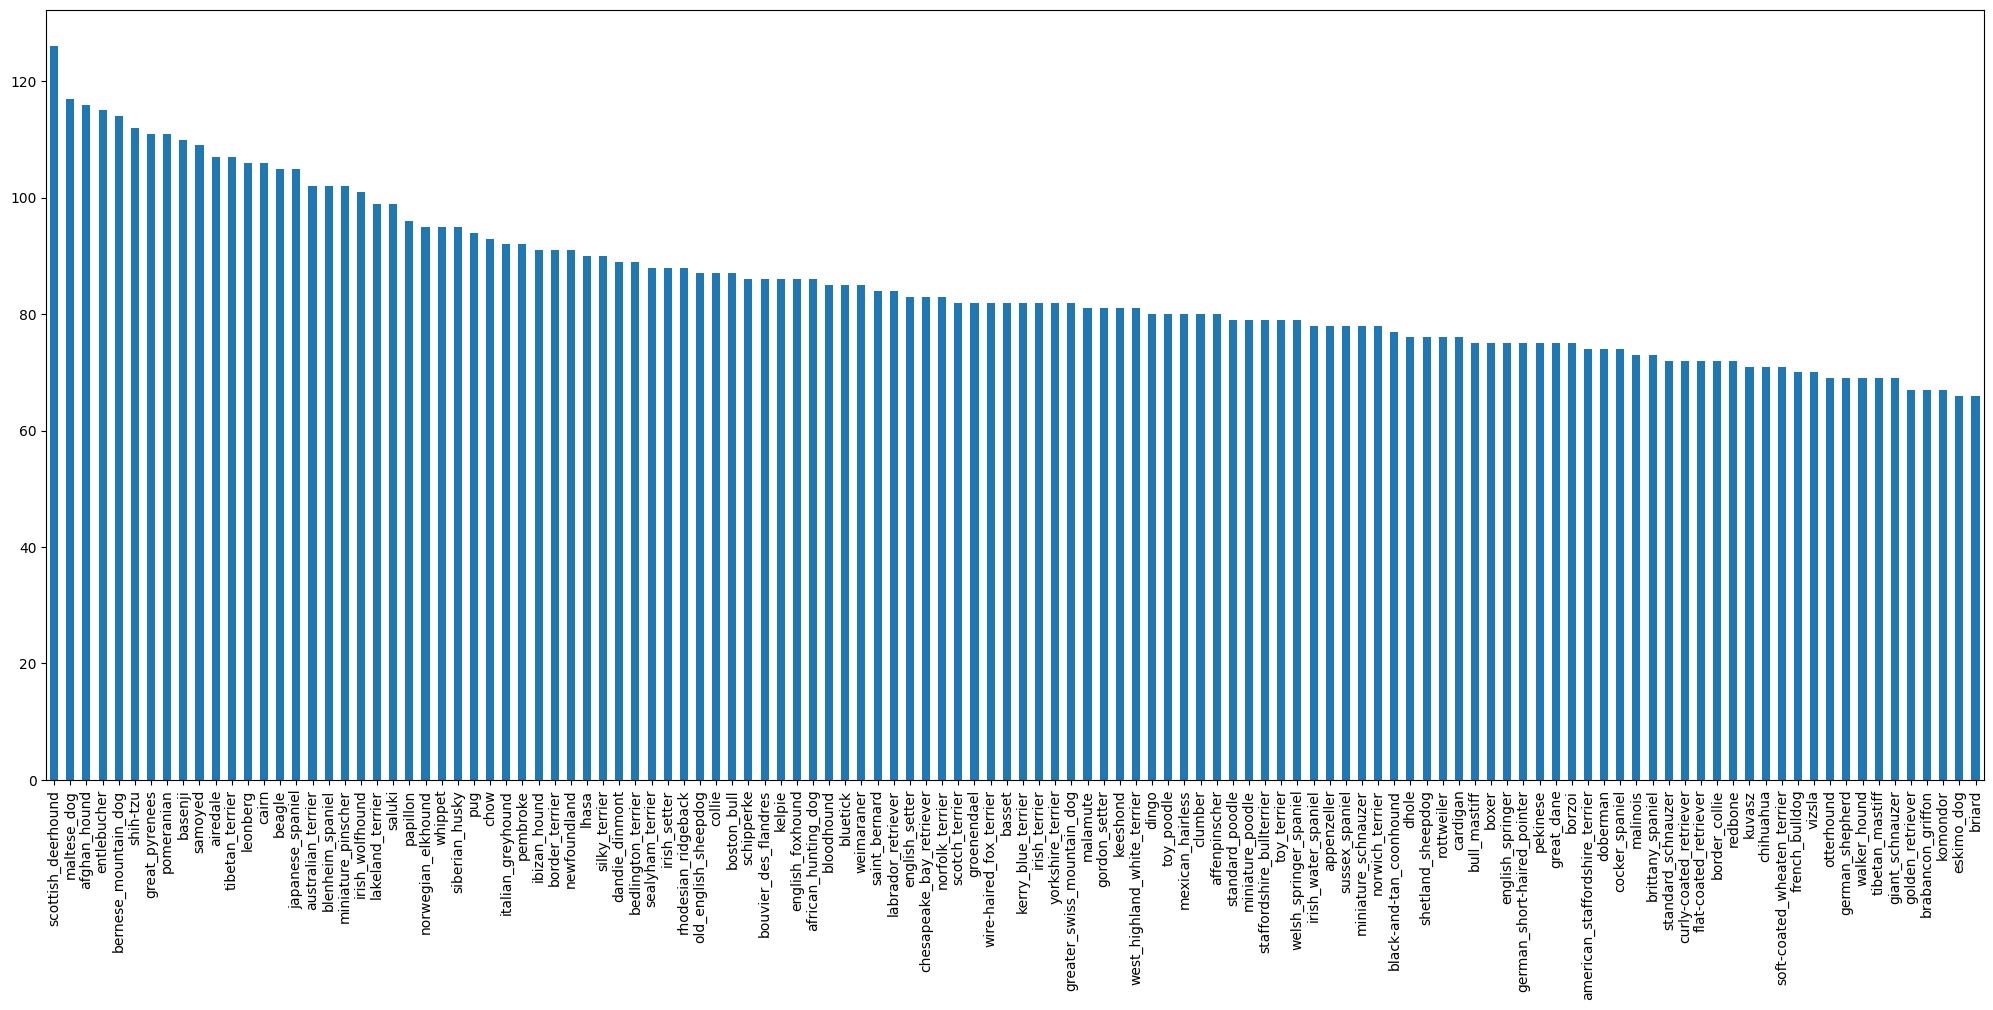

In [ ]:
df.breed.value_counts().plot(kind='bar',figsize = (25,10))

In [ ]:
count_jpg = 0
count_png = 0
for i in os.listdir('/content/train'):
  if i.endswith('jpg'):
    count_jpg+=1
  else:
    count_png+=1
print(f'count_jpg = {count_jpg} count_png = {count_png}')

count_jpg = 10222 count_png = 0


In [16]:
df['id'] = df['id']+'.jpg'

In [ ]:
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


In [17]:
idg = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=30,validation_split=0.1)

In [18]:
batch_size = 64

In [19]:
train = idg.flow_from_dataframe(dataframe = df,
                                directory='/content/train',
                                x_col = 'id',
                                y_col = 'breed',
                                target_size = (380,380),
                                shuffle = False,
                                batch_size = batch_size,
                                subset = 'training')

Found 9200 validated image filenames belonging to 120 classes.


In [20]:
val = idg.flow_from_dataframe(dataframe=df,
                              directory='/content/train',
                              x_col = 'id',
                              y_col = 'breed',
                              target_size = (380,380),
                              shuffle = False,
                              batch_size = batch_size,
                              subset = 'validation')

Found 1022 validated image filenames belonging to 120 classes.


In [ ]:
#Ensemble Model Skeleton

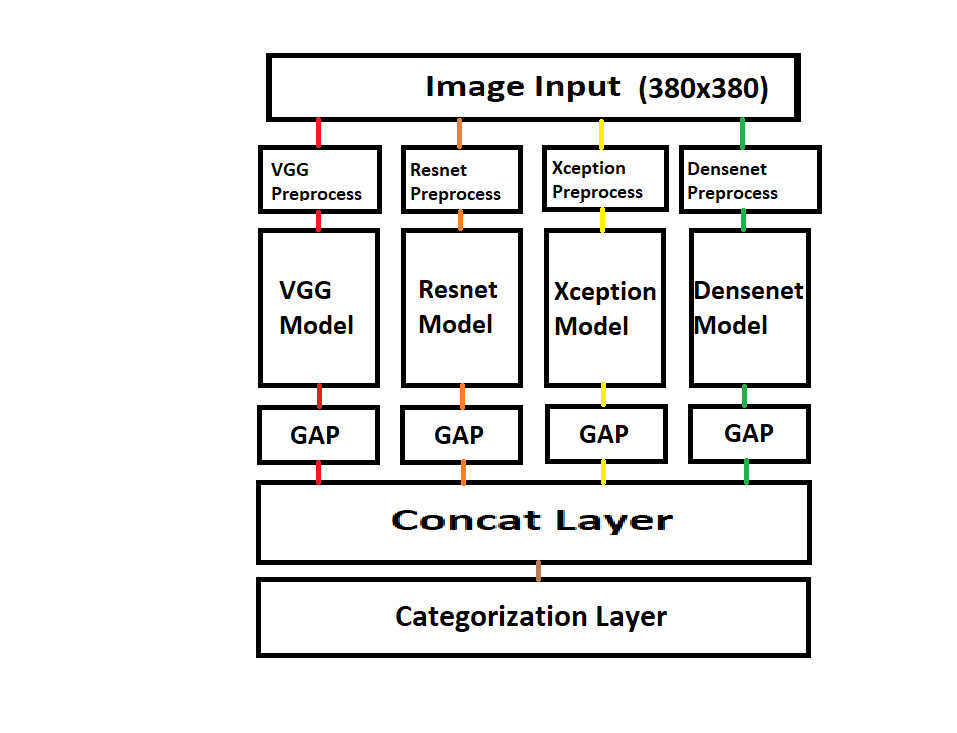

In [21]:
#Input Layer
input = tf.keras.layers.Input((380,380,3),name = 'Input')

#Preprocessing Layer
##VGG
vgg_prep = tf.keras.layers.Lambda(tf.keras.applications.vgg16.preprocess_input,name = 'vgg_prep')(input)

##Resnet
resnet_prep = tf.keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input,name = 'resnet_prep')(input)

##Xception
xception_prep = tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input,name = 'xception_prep')(input)

##Densenet
densenet_prep = tf.keras.layers.Lambda(tf.keras.applications.densenet.preprocess_input,name = 'densenet_prep')(input)

#Model Layer
##VGG
vgg_notop = tf.keras.applications.vgg16.VGG16(include_top = False,input_shape = (380,380,3))
vgg_notop.trainable = False

vgg = vgg_notop(vgg_prep)

#Resnet
resnet_notop = tf.keras.applications.resnet.ResNet50(include_top = False,input_shape = (380,380,3))
resnet_notop.trainable = False

resnet = resnet_notop (resnet_prep)

##Xception
xception_notop = tf.keras.applications.xception.Xception(include_top=False,input_shape = (380,380,3))
xception_notop.trainable = False

xception = xception_notop(xception_prep)

##Densenet
densenet_notop = tf.keras.applications.densenet.DenseNet121(include_top=False,input_shape = (380,380,3))
densenet_notop.trainable = False

densenet = densenet_notop(densenet_prep)

#Global Average Pooling layer
##VGG
vgg_gap = tf.keras.layers.GlobalAveragePooling2D(name = 'vgg_gap')(vgg)

##Resnet
resnet_gap = tf.keras.layers.GlobalAveragePooling2D(name = 'resnet_gap')(resnet)

##Xception
xception_gap = tf.keras.layers.GlobalAveragePooling2D(name = 'xception_gap')(xception)

##Densenet
densenet_gap = tf.keras.layers.GlobalAveragePooling2D(name = 'densenet_gap')(densenet)

#Concatination Layer
concat_layer = tf.keras.layers.Concatenate(name = 'concat_layer')([vgg_gap,resnet_gap,xception_gap,densenet_gap])

# max no. of filters in each model
#vgg #512
#resnet #2048
#xception #2048
#densenet #1024
#hence the output of concatination will be (None,5632)


#Categorization layers
hidden_layer = tf.keras.layers.Dense(256,activation = 'relu',name = 'hidden_layer')(concat_layer)
output = tf.keras.layers.Dense(120,activation = 'softmax',name = 'output')(hidden_layer)

29084464/29084464 [==============================] - 2s 0us/step


In [22]:
final_model = tf.keras.models.Model(inputs = [input], outputs = [output])

In [23]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 380, 380, 3)]        0         []                            
                                                                                                  
 vgg_prep (Lambda)           (None, 380, 380, 3)          0         ['Input[0][0]']               
                                                                                                  
 resnet_prep (Lambda)        (None, 380, 380, 3)          0         ['Input[0][0]']               
                                                                                                  
 xception_prep (Lambda)      (None, 380, 380, 3)          0         ['Input[0][0]']               
                                                                                              

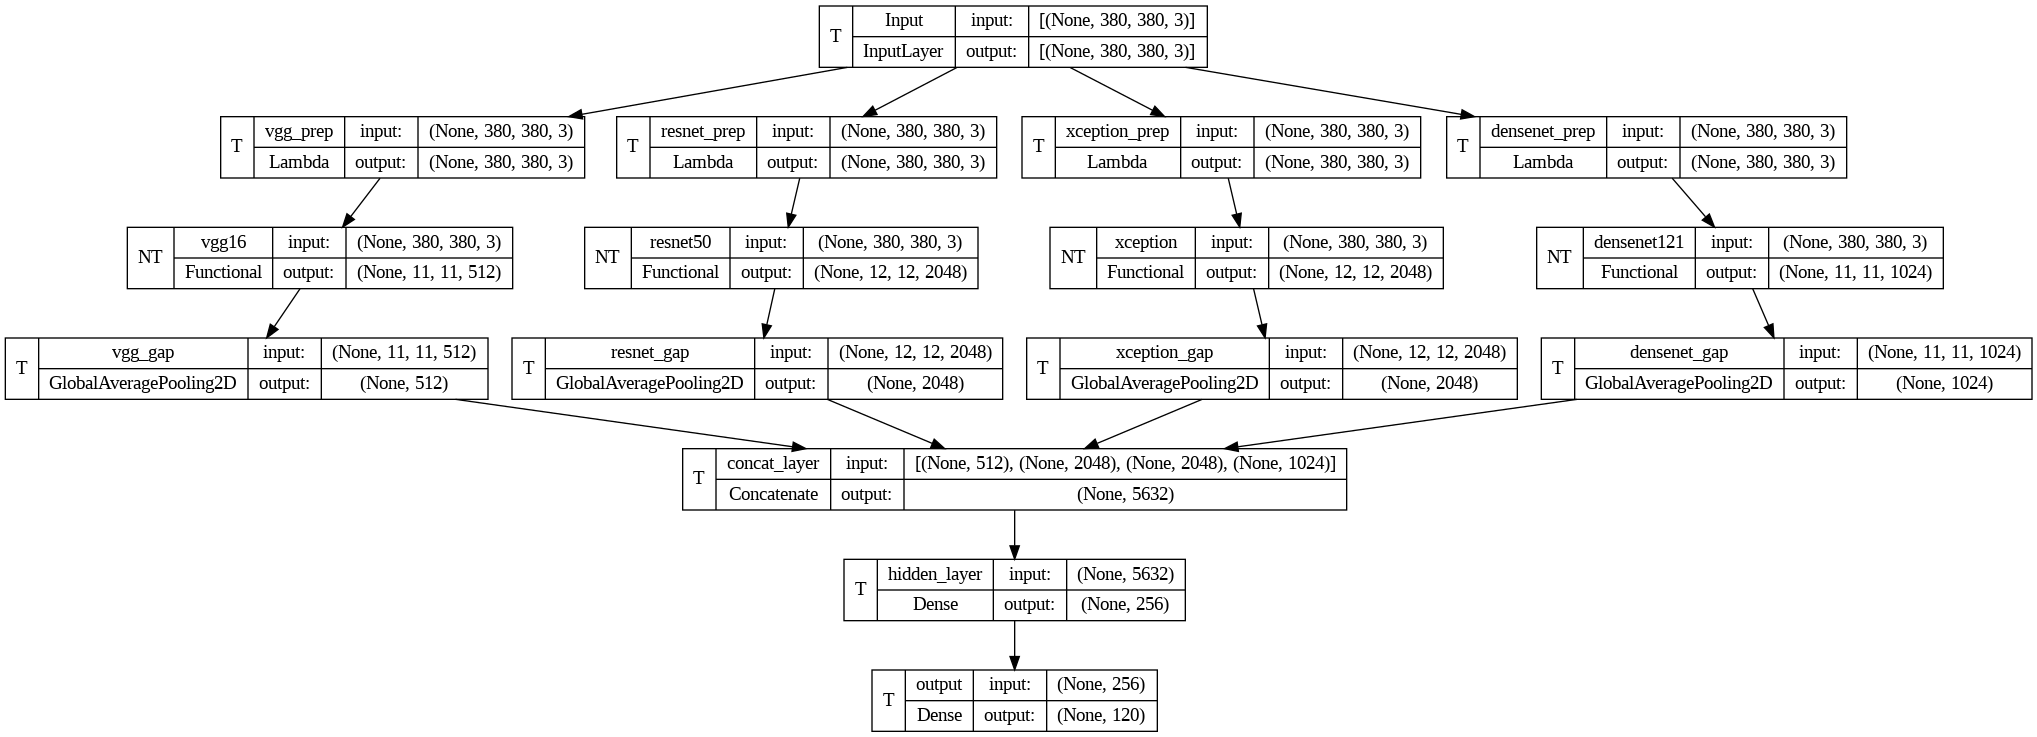

In [ ]:
tf.keras.utils.plot_model(final_model,
                          show_shapes = True,
                          show_trainable=True)

In [24]:
final_model.compile(optimizer = tf.keras.optimizers.SGD(),
                    loss = tf.keras.losses.categorical_crossentropy,
                    metrics = ['accuracy'])

In [25]:
train.image_shape,val.image_shape,final_model.input_shape

((380, 380, 3), (380, 380, 3), (None, 380, 380, 3))

In [26]:
final_model.fit(train,
                batch_size = batch_size,
                epochs = 10,
                validation_data = val)

Epoch 1/10


KeyboardInterrupt: 

In [ ]:
#final_model = tf.keras.models.load_model("/content/drive/MyDrive/Ensemble Model")

In [ ]:
#final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 380, 380, 3)]        0         []                            
                                                                                                  
 vgg_prep (Lambda)           (None, 380, 380, 3)          0         ['Input[0][0]']               
                                                                                                  
 resnet_prep (Lambda)        (None, 380, 380, 3)          0         ['Input[0][0]']               
                                                                                                  
 xception_prep (Lambda)      (None, 380, 380, 3)          0         ['Input[0][0]']               
                                                                                            

AttributeError: ignored

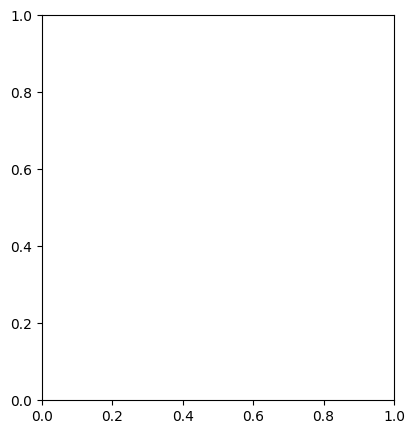

In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(final_model.history.history['accuracy'],label = 'Accuracy')
plt.plot(final_model.history.history['val_accuracy'],label = 'Validation Accuracy')
plt.title('Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(final_model.history.history['loss'],label = 'Loss')
plt.plot(final_model.history.history['val_loss'],label = 'Validation Loss')
plt.title('Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
#final_model.save('/content/drive/MyDrive/Ensemble Model')

In [ ]:
ind = []
val = []
for idx,i in enumerate(train.class_indices):
  ind.append(idx)
  val.append(i)
class_label = pd.DataFrame(val,ind)
class_label

,0
0,affenpinscher
1,afghan_hound
2,african_hunting_dog
3,airedale
4,american_staffordshire_terrier
...,...
115,welsh_springer_spaniel
116,west_highland_white_terrier
117,whippet
118,wire-haired_fox_terrier


In [ ]:
def image_pred(path):
  image = cv2.imread(os.path.join(path))
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  plt.imshow(image)
  image = cv2.resize(image,(380,380))
  image = np.expand_dims(image,axis = 0)
  d = final_model.predict(image)
  indx = np.argmax(d)
  titl = class_label[class_label.index==indx].values[0][0]
  plt.title(titl)
  plt.show()
  return(titl)

1/1 [==============================] - 3s 3s/step


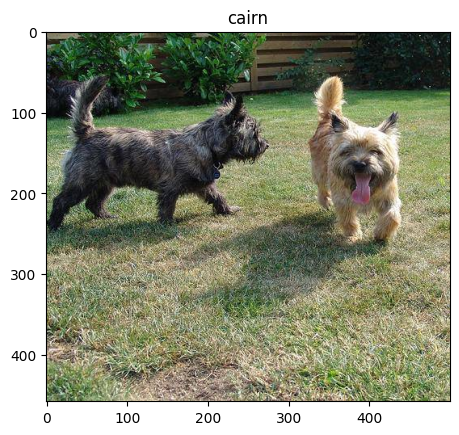

'cairn'

In [ ]:
img = np.random.choice(os.listdir('/content/train'),1)[0]
image = os.path.join('/content/train',img)
image_pred(image)

In [ ]:
df[df['id']==img].breed

5323    cairn
Name: breed, dtype: object

In [ ]:
prob = []
p_class = []
for i in tqdm(df['id']):
  path = os.path.join('/content/train/',i)
  image = cv2.imread(os.path.join(path))
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(380,380))
  image = np.expand_dims(image,axis = 0)
  d = final_model.predict(image,verbose = 0)
  indx = np.argmax(d)
  prob.append(indx)
  titl = class_label[class_label.index==indx].values[0][0]
  p_class.append(titl)

  0%|          | 0/10222 [00:00<?, ?it/s]

In [ ]:
pred = pd.DataFrame({'prob':prob,'p_class':p_class})

In [ ]:
pred.shape

(10222, 2)

In [ ]:
pred['a_class'] = df['breed']
pred['id']=df['id']

In [ ]:
pred = pred[['id','a_class','p_class','prob']]

In [ ]:
(len(pred[pred['a_class']==pred['p_class']])/len(pred))*100 #accuracy

89.13128546272745

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(pred['a_class'],pred['p_class'])

array([[ 76,   0,   0, ...,   0,   0,   0],
       [  0, 114,   0, ...,   0,   0,   0],
       [  0,   0,  85, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  90,   0,   0],
       [  0,   0,   0, ...,   0,  55,   0],
       [  0,   0,   0, ...,   0,   0,  74]])